## Import packages

In [1]:
from opt import get_opts
from config import Config
from models import BasicNeRF
from model_utils import generate_rays, perform_volume_rendering
from render import pose_spherical

import gin
from pickletools import optimize

import numpy as np
from jax import numpy as jnp
from jax import jit, pmap, value_and_grad, lax, \
                local_device_count, random, \
                device_put_replicated, local_devices

from flax.jax_utils import unreplicate
from flax.training import train_state, common_utils
import optax

from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio

## Load configurations and data

In [2]:
gin_config_path = "configs/default.gin"
gin.parse_config_file(gin_config_path)

config = Config()

# load data
data = np.load("tiny_nerf_data.npz")
images = data["images"]
poses = data["poses"]
focal = float(data["focal"])

# split data into train and val
_, img_ht, img_wid, _ = images.shape
train_images, train_poses = images[:100], poses[:100]
val_image, val_pose = images[101], poses[101]

## Define routines for Training

In [3]:
def init_model(key, input_pts_shape):
    # create model
    model = BasicNeRF()

    # init model
    init_params = jit(model.init)({"params":key}, jnp.ones(input_pts_shape))

    return model, init_params["params"]


def train_step(state, batch, rng):
    """
    Training Step:
    state is comb of model state and optimizer state
    """
    inputs, targets = batch

    # compute loss in a stateless manner to save memory
    def loss_fn(params):
        ray_origins, ray_directions = inputs
        model_fn = lambda x: state.apply_fn({"params": params}, x)
        pred_rgbs, *_ = perform_volume_rendering(model_fn, ray_origins, ray_directions, rng)
        return jnp.mean( (pred_rgbs - targets)**2 )

    # get loss value and gradients    
    train_loss, gradients = value_and_grad(loss_fn)(state.params)

    # get averaged train loss
    train_loss = jnp.mean(train_loss)

    # compute all-reduce mean on gradients over the pmapped axis
    gradients = lax.pmean(gradients, axis_name="batch")

    # update model params & optimizer state
    new_state = state.apply_gradients(grads=gradients)

    # compute PSNR
    train_psnr = -10.0 * jnp.log(train_loss) / jnp.log(10.0)
    return train_loss, train_psnr, new_state

## Generate rays and init model

In [4]:
# create train and validation rays
train_rays = np.stack(list(map(lambda x: generate_rays(img_ht, img_wid, focal, x), train_poses)))
val_rays = generate_rays(img_ht, img_wid, focal, val_pose)

# number of devices
n_devices = local_device_count()
print("Using {} devices to compute".format(n_devices))

# rand number generation
key, rng = random.split(random.PRNGKey(0))

# init the model
model, params = init_model(key, (img_ht*img_wid, 3))

# optimizer
optimizer = optax.adam(learning_rate=config.lr)

# training state
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

# transfer arrays in the state to specified devices and form ShardedDeviceArrays
state = device_put_replicated(state, local_devices())

Using 1 devices to compute


## Define routines for validation

In [5]:
@jit
def validation_step(state):
    """
    Validation
    """
    model_fn = lambda x: state.apply_fn({"params": state.params}, x)
    ray_origins, ray_directions = val_rays

    pred_rgb, pred_depth, *_ = perform_volume_rendering(model_fn, ray_origins, ray_directions)

    val_loss = jnp.mean( (pred_rgb - val_image)**2 )
    val_psnr = -10.0 * jnp.log(val_loss) / jnp.log(10.0)
    return pred_rgb, pred_depth, val_psnr, val_loss

In [6]:
def train_and_evaluate(state, train_step_fn, validation_step_fn):
    train_loss_history, train_psnr_history = [], []
    val_loss_history, val_psnr_history = [], []

    for epoch in tqdm(range(config.train_epochs)):
        # shard random number generators
        rng_index, rng_epoch = random.split(random.fold_in(rng, epoch))
        sharded_rngs = common_utils.shard_prng_key(rng_epoch)

        # create training batch 
        train_index = random.randint(rng_index, (n_devices,), minval=0, maxval=len(train_rays))
        train_batch = train_rays[tuple(train_index), ...],\
                      train_images[tuple(train_index), ...]
        
        # perform training step
        train_loss, train_psnr, state = train_step_fn(state, train_batch, sharded_rngs)
        avg_train_loss = np.asarray(np.mean(train_loss))
        avg_train_psnr = np.asarray(np.mean(train_psnr))
        train_loss_history.append(avg_train_loss)
        train_psnr_history.append(avg_train_psnr)
        
        # logging
        print("Train loss @ epoch {}: {}".format(epoch, avg_train_loss))
        print("Train psnr @ epoch {}: {}".format(epoch, avg_train_psnr))

        # perform validation step
        validation_state = unreplicate(state)
        rgb, depth, val_psnr, val_loss = validation_step_fn(validation_state)
        avg_val_loss = np.asarray(np.mean(val_loss))
        avg_val_psnr = np.asarray(np.mean(val_psnr))
        val_loss_history.append(avg_val_loss)
        val_psnr_history.append(avg_val_psnr)
        
        # logging
        print("Val loss @ epoch {}: {}".format(epoch, avg_train_loss))
        print("Val psnr @ epoch {}: {}".format(epoch, avg_train_psnr))

        # plot result at every plot interval
        if epoch % config.plot_interval == 0:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
            ax1.imshow(rgb)
            ax1.set_title("Predicted RGB at epoch: {}".format(epoch))
            ax1.axis('off')
            ax2.imshow(depth)
            ax2.set_title('Predicted RGB at epoch: {}'.format(epoch))
            ax2.axis('off')
            plt.show()
    
    inference_state = unreplicate(state)
    history = {
        'train_loss': train_loss_history,
        'train_psnr': train_psnr_history,
        'val_loss': val_loss_history,
        'val_psnr': val_psnr_history
    }
    return state, inference_state, history

## Start training

  0%|          | 0/1000 [00:00<?, ?it/s]

Train loss @ epoch 0: 0.2013019174337387
Train psnr @ epoch 0: 6.961520195007324
Val loss @ epoch 0: 0.2013019174337387
Val psnr @ epoch 0: 6.961520195007324


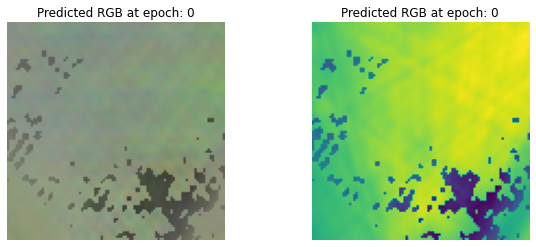

  0%|          | 1/1000 [00:23<6:23:10, 23.01s/it]

Train loss @ epoch 1: 0.21620464324951172
Train psnr @ epoch 1: 6.6513495445251465


  0%|          | 2/1000 [00:34<4:26:44, 16.04s/it]

Val loss @ epoch 1: 0.21620464324951172
Val psnr @ epoch 1: 6.6513495445251465
Train loss @ epoch 2: 0.2087799608707428
Train psnr @ epoch 2: 6.803111553192139


  0%|          | 3/1000 [00:42<3:27:19, 12.48s/it]

Val loss @ epoch 2: 0.2087799608707428
Val psnr @ epoch 2: 6.803111553192139
Train loss @ epoch 3: 0.18711969256401062
Train psnr @ epoch 3: 7.278804779052734


  0%|          | 4/1000 [00:51<3:06:43, 11.25s/it]

Val loss @ epoch 3: 0.18711969256401062
Val psnr @ epoch 3: 7.278804779052734
Train loss @ epoch 4: 0.20103341341018677
Train psnr @ epoch 4: 6.9673171043396


  0%|          | 5/1000 [00:59<2:48:12, 10.14s/it]

Val loss @ epoch 4: 0.20103341341018677
Val psnr @ epoch 4: 6.9673171043396
Train loss @ epoch 5: 0.19650472700595856
Train psnr @ epoch 5: 7.066269397735596
Val loss @ epoch 5: 0.19650472700595856
Val psnr @ epoch 5: 7.066269397735596


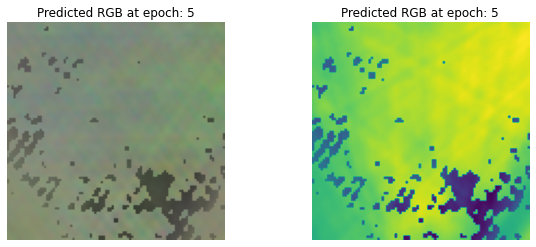

  1%|          | 6/1000 [01:09<2:43:10,  9.85s/it]

Train loss @ epoch 6: 0.17590554058551788
Train psnr @ epoch 6: 7.547204494476318


  1%|          | 7/1000 [01:17<2:32:10,  9.19s/it]

Val loss @ epoch 6: 0.17590554058551788
Val psnr @ epoch 6: 7.547204494476318
Train loss @ epoch 7: 0.19173972308635712
Train psnr @ epoch 7: 7.172878742218018


  1%|          | 8/1000 [01:27<2:40:06,  9.68s/it]

Val loss @ epoch 7: 0.19173972308635712
Val psnr @ epoch 7: 7.172878742218018
Train loss @ epoch 8: 0.1628876030445099
Train psnr @ epoch 8: 7.881119251251221


  1%|          | 9/1000 [01:35<2:27:57,  8.96s/it]

Val loss @ epoch 8: 0.1628876030445099
Val psnr @ epoch 8: 7.881119251251221
Train loss @ epoch 9: 0.16930539906024933
Train psnr @ epoch 9: 7.713291168212891


  1%|          | 10/1000 [01:42<2:21:12,  8.56s/it]

Val loss @ epoch 9: 0.16930539906024933
Val psnr @ epoch 9: 7.713291168212891
Train loss @ epoch 10: 0.1749969869852066
Train psnr @ epoch 10: 7.5696940422058105
Val loss @ epoch 10: 0.1749969869852066
Val psnr @ epoch 10: 7.5696940422058105


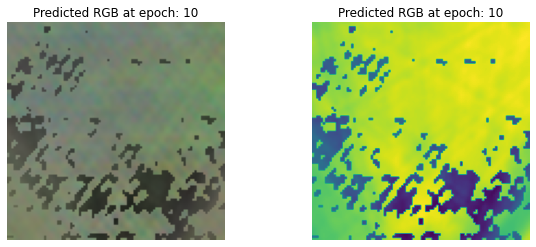

  1%|          | 11/1000 [01:57<2:55:48, 10.67s/it]


KeyboardInterrupt: 

In [7]:

# perform training now
# Apply the transform jax.pmap on the train_step to parallelize it on XLA devices
# While vmap vectorizes a function by adding a batch dimension to every primitive operation 
# in the function, pmap replicates the function and executes each replica 
# on its own XLA device in parallel.
parallelized_train_step = pmap(train_step, axis_name="batch")
state, inference_state, history = train_and_evaluate(state, parallelized_train_step, validation_step)


## Render the scene

In [8]:
@jit
def get_renderings(rays):
    model_fn = lambda x: inference_state.apply_fn(
        {"params": inference_state.params}, x
    )

    ray_origins, ray_directions = rays
    rgb, depth, acc, disparity, opacities = perform_volume_rendering(
        model_fn, ray_origins, ray_directions
    )
    rgb = (255 * jnp.clip(rgb, 0, 1)).astype(jnp.uint8)
    return rgb, depth, acc, disparity, opacities


# Create a 360 degree video of the 3D scene
def get_frames():
    video_angle = jnp.linspace(0.0, 360.0, 120, endpoint=False)
    camera_to_world_transform = map(lambda th: pose_spherical(th, -30.0, 4.0), video_angle)
    rays = np.stack(list(map(
        lambda x: generate_rays(
            img_ht, img_wid, focal, x[:3, :4]
        ), camera_to_world_transform
    )))
    rgb_frames, depth_frames, acc_maps, disparity_maps, opacities = lax.map(get_renderings, rays)
    rgb_frames = np.asarray(rgb_frames)
    depth_frames = np.asarray(depth_frames)
    acc_maps = np.asarray(acc_maps * 255.)
    disparity_maps = np.asarray(disparity_maps * 255.)
    return rgb_frames, depth_frames, acc_maps, disparity_maps

In [9]:
# render the scene
rgb_frames, depth_frames, acc_maps, disparity_maps = get_frames()

NameError: name 'inference_state' is not defined